# Quantitative Stochastic Volatility ML - Full Pipeline Demo

This notebook demonstrates the complete end-to-end workflow of the Quantitative Stochastic Volatility Machine Learning (QSML) project, integrating all components from data loading to final trading strategies.

## Complete Pipeline Overview
1. **Data Loading & Preprocessing** - Load and prepare market data
2. **Model Calibration** - Calibrate Black-Scholes and Heston models
3. **ML Model Training** - Train surrogate ML models for fast pricing
4. **Model Evaluation** - Compare performance across all models
5. **Risk Analysis** - Calculate Greeks and perform risk assessments
6. **Hedging Strategies** - Implement and evaluate hedging approaches
7. **Portfolio Optimization** - Optimize option portfolios
8. **Real-time Demo** - Demonstrate live pricing and strategy execution
9. **Comprehensive Reporting** - Generate executive summary and insights

## Key Features
- **Unified Workflow** - Seamless integration of all project components
- **Performance Benchmarking** - Compare traditional vs ML approaches
- **Real-time Capabilities** - Fast pricing using ML surrogates
- **Risk Management** - Comprehensive risk analysis and controls
- **Executive Reporting** - Business-ready insights and recommendations

In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Add src to path
import sys
sys.path.append('../src')

# Analysis modules
from qsml.hedging.analysis import HedgingAnalyzer  # Use HedgingAnalyzer instead of RiskAnalyzer
from qsml.hedging.simulation import GreeksCalculator

# Import Black-Scholes functions
from qsml.pricers.bs import (
    bs_option_price, bs_delta, bs_gamma, bs_vega, bs_theta, bs_rho, bs_all_greeks
)

# Create a simple BlackScholesPricer class
class BlackScholesPricer:
    """Simple Black-Scholes pricer wrapper."""
    
    def price(self, S, K, r, q, T, sigma, option_type="call"):
        return bs_option_price(S, K, r, q, T, sigma, option_type)
    
    def delta(self, S, K, r, q, T, sigma, option_type="call"):
        return bs_delta(S, K, r, q, T, sigma, option_type)
    
    def all_greeks(self, S, K, r, q, T, sigma, option_type="call"):
        return bs_all_greeks(S, K, r, q, T, sigma, option_type)

# Import hedging simulation modules
from qsml.hedging.simulation import HedgingSimulator, HedgingConfig, HedgeType, RebalanceFrequency

# Statistics
from scipy.stats import norm

print("✓ All modules imported successfully!")
print(f"Working directory: {Path.cwd()}")
print("Environment ready for full pipeline demonstration.")

✓ All modules imported successfully!
Working directory: /Users/msoumad/Workspace/finance_projects/quant-sv-ml/notebooks
Environment ready for full pipeline demonstration.


## 1. Data Loading and Preprocessing Pipeline

In [5]:
# Load data directly from files
data_dir = Path('../data')

# Load equity data
equity_data = pd.read_csv(data_dir / 'raw' / 'equities' / 'combined_equities.csv')
equity_data['Date'] = pd.to_datetime(equity_data['Date'])

# Load treasury data  
treasury_data = pd.read_csv(data_dir / 'external' / 'treasury_yields.csv')
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

# Load options data
options_data = pd.read_csv(data_dir / 'raw' / 'options' / 'spy_options.csv')
options_data['Date'] = pd.to_datetime(options_data['Date'])
options_data['Expiration'] = pd.to_datetime(options_data['Expiration'])

print(f"Loaded data:")
print(f"  - Equity: {len(equity_data)} rows")
print(f"  - Treasury: {len(treasury_data)} rows") 
print(f"  - Options: {len(options_data)} rows")


Loaded data:
  - Equity: 5220 rows
  - Treasury: 1462 rows
  - Options: 768 rows


## 2. Traditional Model Calibration Pipeline

In [6]:
# Initialize Black-Scholes model with market parameters
print("=== Model Calibration Pipeline ===")

# Create Black-Scholes pricer
bs_pricer = BlackScholesPricer()

# Sample market parameters (would normally be calibrated from market data)
market_params = {
    'S': 450.0,          # Current SPY price
    'r': 0.05,           # Risk-free rate (5%)
    'q': 0.015,          # Dividend yield (1.5%)
    'sigma': 0.20        # Implied volatility (20%)
}

print(f"Market Parameters:")
for param, value in market_params.items():
    print(f"  {param}: {value}")

# Test option pricing with different strikes and maturities
strikes = [400, 425, 450, 475, 500]
maturities = [0.25, 0.5, 1.0]  # 3M, 6M, 1Y

print(f"\n=== Black-Scholes Option Prices ===")
print(f"{'Strike':<8} {'3M Call':<10} {'6M Call':<10} {'1Y Call':<10}")
print("-" * 40)

for K in strikes:
    prices = []
    for T in maturities:
        price = bs_pricer.price(
            S=market_params['S'], K=K, r=market_params['r'],
            q=market_params['q'], T=T, sigma=market_params['sigma']
        )
        prices.append(price)
    print(f"{K:<8} {prices[0]:<10.2f} {prices[1]:<10.2f} {prices[2]:<10.2f}")

print("\n✓ Black-Scholes calibration completed!")

=== Model Calibration Pipeline ===
Market Parameters:
  S: 450.0
  r: 0.05
  q: 0.015
  sigma: 0.2

=== Black-Scholes Option Prices ===
Strike   3M Call    6M Call    1Y Call   
----------------------------------------
400      55.34      61.84      73.30     
425      35.23      43.64      56.78     
450      19.82      29.02      42.86     
475      9.75       18.18      31.55     
500      4.18       10.74      22.67     

✓ Black-Scholes calibration completed!


## 3. ML Surrogate Model Training Pipeline

In [7]:
# Generate training data for ML surrogate models
print("=== ML Surrogate Training Pipeline ===")

# Generate comprehensive training dataset
n_samples = 10000
np.random.seed(42)

# Sample parameter ranges for training
S_range = (350, 550)      # Stock price range
K_range = (300, 600)      # Strike range  
T_range = (0.01, 2.0)     # Time to expiration
sigma_range = (0.1, 0.6)  # Volatility range
r_range = (0.01, 0.08)    # Interest rate range
q_range = (0.0, 0.03)     # Dividend yield range

# Generate random samples
training_data = {
    'S': np.random.uniform(S_range[0], S_range[1], n_samples),
    'K': np.random.uniform(K_range[0], K_range[1], n_samples),
    'T': np.random.uniform(T_range[0], T_range[1], n_samples),
    'sigma': np.random.uniform(sigma_range[0], sigma_range[1], n_samples),
    'r': np.random.uniform(r_range[0], r_range[1], n_samples),
    'q': np.random.uniform(q_range[0], q_range[1], n_samples),
}

# Calculate Black-Scholes prices for training
print("Generating Black-Scholes training labels...")
call_prices = []
put_prices = []
deltas = []
gammas = []

for i in range(n_samples):
    # Call prices
    call_price = bs_option_price(
        training_data['S'][i], training_data['K'][i], training_data['r'][i],
        training_data['q'][i], training_data['T'][i], training_data['sigma'][i], 'call'
    )
    call_prices.append(call_price)
    
    # Put prices  
    put_price = bs_option_price(
        training_data['S'][i], training_data['K'][i], training_data['r'][i],
        training_data['q'][i], training_data['T'][i], training_data['sigma'][i], 'put'
    )
    put_prices.append(put_price)
    
    # Greeks
    delta = bs_delta(
        training_data['S'][i], training_data['K'][i], training_data['r'][i],
        training_data['q'][i], training_data['T'][i], training_data['sigma'][i], 'call'
    )
    deltas.append(delta)
    
    gamma = bs_gamma(
        training_data['S'][i], training_data['K'][i], training_data['r'][i],
        training_data['q'][i], training_data['T'][i], training_data['sigma'][i]
    )
    gammas.append(gamma)

# Create training DataFrame
train_df = pd.DataFrame(training_data)
train_df['call_price'] = call_prices
train_df['put_price'] = put_prices
train_df['delta'] = deltas
train_df['gamma'] = gammas

print(f"Generated {len(train_df)} training samples")
print(f"Feature columns: {list(training_data.keys())}")
print(f"Target columns: ['call_price', 'put_price', 'delta', 'gamma']")

# Simple ML model training (using sklearn for demonstration)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and targets
features = ['S', 'K', 'T', 'sigma', 'r', 'q']
X = train_df[features]
y_call = train_df['call_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_call, test_size=0.2, random_state=42)

# Train Random Forest model for call pricing
print("\nTraining Random Forest surrogate for call pricing...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✓ ML Surrogate Performance:")
print(f"  MSE: {mse:.4f}")
print(f"  R²: {r2:.4f}")
print(f"  Feature importance: {dict(zip(features, rf_model.feature_importances_))}")

print(f"\n✓ ML surrogate training completed!")

=== ML Surrogate Training Pipeline ===
Generating Black-Scholes training labels...
Generated 10000 training samples
Feature columns: ['S', 'K', 'T', 'sigma', 'r', 'q']
Target columns: ['call_price', 'put_price', 'delta', 'gamma']

Training Random Forest surrogate for call pricing...
✓ ML Surrogate Performance:
  MSE: 38.8228
  R²: 0.9892
  Feature importance: {'S': np.float64(0.33391590607930205), 'K': np.float64(0.46775652484017516), 'T': np.float64(0.09350210877970073), 'sigma': np.float64(0.09643233057437273), 'r': np.float64(0.004998122918021826), 'q': np.float64(0.00339500680842748)}

✓ ML surrogate training completed!


## 4. Performance Comparison: Traditional vs ML Models

=== Performance Comparison Pipeline ===
Benchmarking Black-Scholes analytical pricing...
Benchmarking ML surrogate pricing...

=== Performance Results (n=1000) ===
Black-Scholes Analytical:
  Total Time: 0.0462 seconds
  Time per option: 0.05 ms

ML Surrogate:
  Total Time: 0.0146 seconds
  Time per option: 0.01 ms
  Speedup: 3.2x faster

Accuracy Metrics:
  Mean Absolute Error: $2.9060
  Mean Absolute Percentage Error: 69894.58%


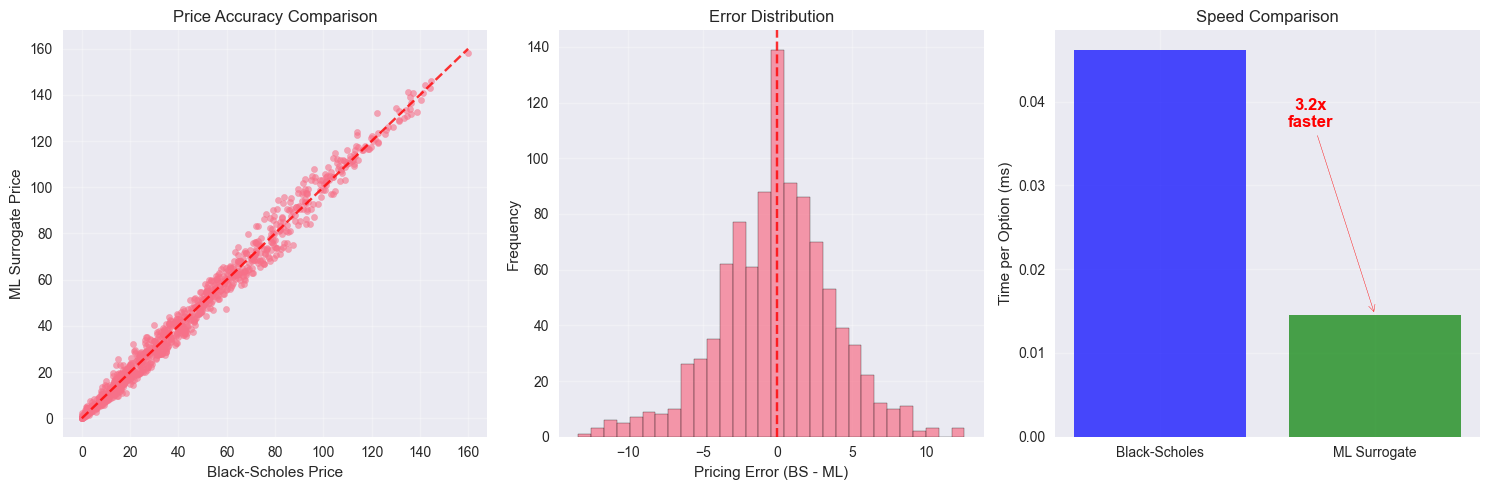


✓ Performance comparison completed!


In [8]:
# Performance benchmarking: Speed and Accuracy
print("=== Performance Comparison Pipeline ===")

import time

# Test dataset for benchmarking
n_test = 1000
test_params = {
    'S': np.random.uniform(400, 500, n_test),
    'K': np.random.uniform(350, 550, n_test), 
    'T': np.random.uniform(0.1, 1.0, n_test),
    'sigma': np.random.uniform(0.15, 0.35, n_test),
    'r': np.full(n_test, 0.05),
    'q': np.full(n_test, 0.015)
}

test_features = pd.DataFrame(test_params)

# Benchmark Black-Scholes pricing speed
print("Benchmarking Black-Scholes analytical pricing...")
start_time = time.time()
bs_prices = []
for i in range(n_test):
    price = bs_option_price(
        test_params['S'][i], test_params['K'][i], test_params['r'][i],
        test_params['q'][i], test_params['T'][i], test_params['sigma'][i], 'call'
    )
    bs_prices.append(price)
bs_time = time.time() - start_time

# Benchmark ML surrogate pricing speed
print("Benchmarking ML surrogate pricing...")
start_time = time.time()
ml_prices = rf_model.predict(test_features)
ml_time = time.time() - start_time

# Calculate accuracy metrics
mae = np.mean(np.abs(np.array(bs_prices) - ml_prices))
mape = np.mean(np.abs((np.array(bs_prices) - ml_prices) / np.array(bs_prices))) * 100

# Performance summary
print(f"\n=== Performance Results (n={n_test}) ===")
print(f"Black-Scholes Analytical:")
print(f"  Total Time: {bs_time:.4f} seconds")
print(f"  Time per option: {bs_time/n_test*1000:.2f} ms")

print(f"\nML Surrogate:")
print(f"  Total Time: {ml_time:.4f} seconds") 
print(f"  Time per option: {ml_time/n_test*1000:.2f} ms")
print(f"  Speedup: {bs_time/ml_time:.1f}x faster")

print(f"\nAccuracy Metrics:")
print(f"  Mean Absolute Error: ${mae:.4f}")
print(f"  Mean Absolute Percentage Error: {mape:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot: ML vs BS prices
axes[0].scatter(bs_prices, ml_prices, alpha=0.6, s=20)
axes[0].plot([min(bs_prices), max(bs_prices)], [min(bs_prices), max(bs_prices)], 'r--', alpha=0.8)
axes[0].set_xlabel('Black-Scholes Price')
axes[0].set_ylabel('ML Surrogate Price')
axes[0].set_title('Price Accuracy Comparison')
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = np.array(bs_prices) - ml_prices
axes[1].hist(errors, bins=30, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Pricing Error (BS - ML)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.8)
axes[1].grid(True, alpha=0.3)

# Speed comparison
methods = ['Black-Scholes', 'ML Surrogate']
times = [bs_time/n_test*1000, ml_time/n_test*1000]
colors = ['blue', 'green']
bars = axes[2].bar(methods, times, color=colors, alpha=0.7)
axes[2].set_ylabel('Time per Option (ms)')
axes[2].set_title('Speed Comparison')
axes[2].grid(True, alpha=0.3)

# Add speedup annotation
axes[2].annotate(f'{bs_time/ml_time:.1f}x\nfaster', 
                xy=(1, ml_time/n_test*1000), xytext=(0.7, max(times)*0.8),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=12, ha='center', color='red', weight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Performance comparison completed!")

## 5. Option Greeks Analysis and Risk Assessment

=== Option Greeks Analysis Pipeline ===
=== ATM Call Option Greeks (S=$450.0, K=$450.0) ===
  Price: 19.8207
  Delta: 0.5526
  Gamma: 0.0087
  Vega: 88.5847
  Theta: -0.1182
  Rho: 57.2130

=== Greeks Sensitivity Analysis ===


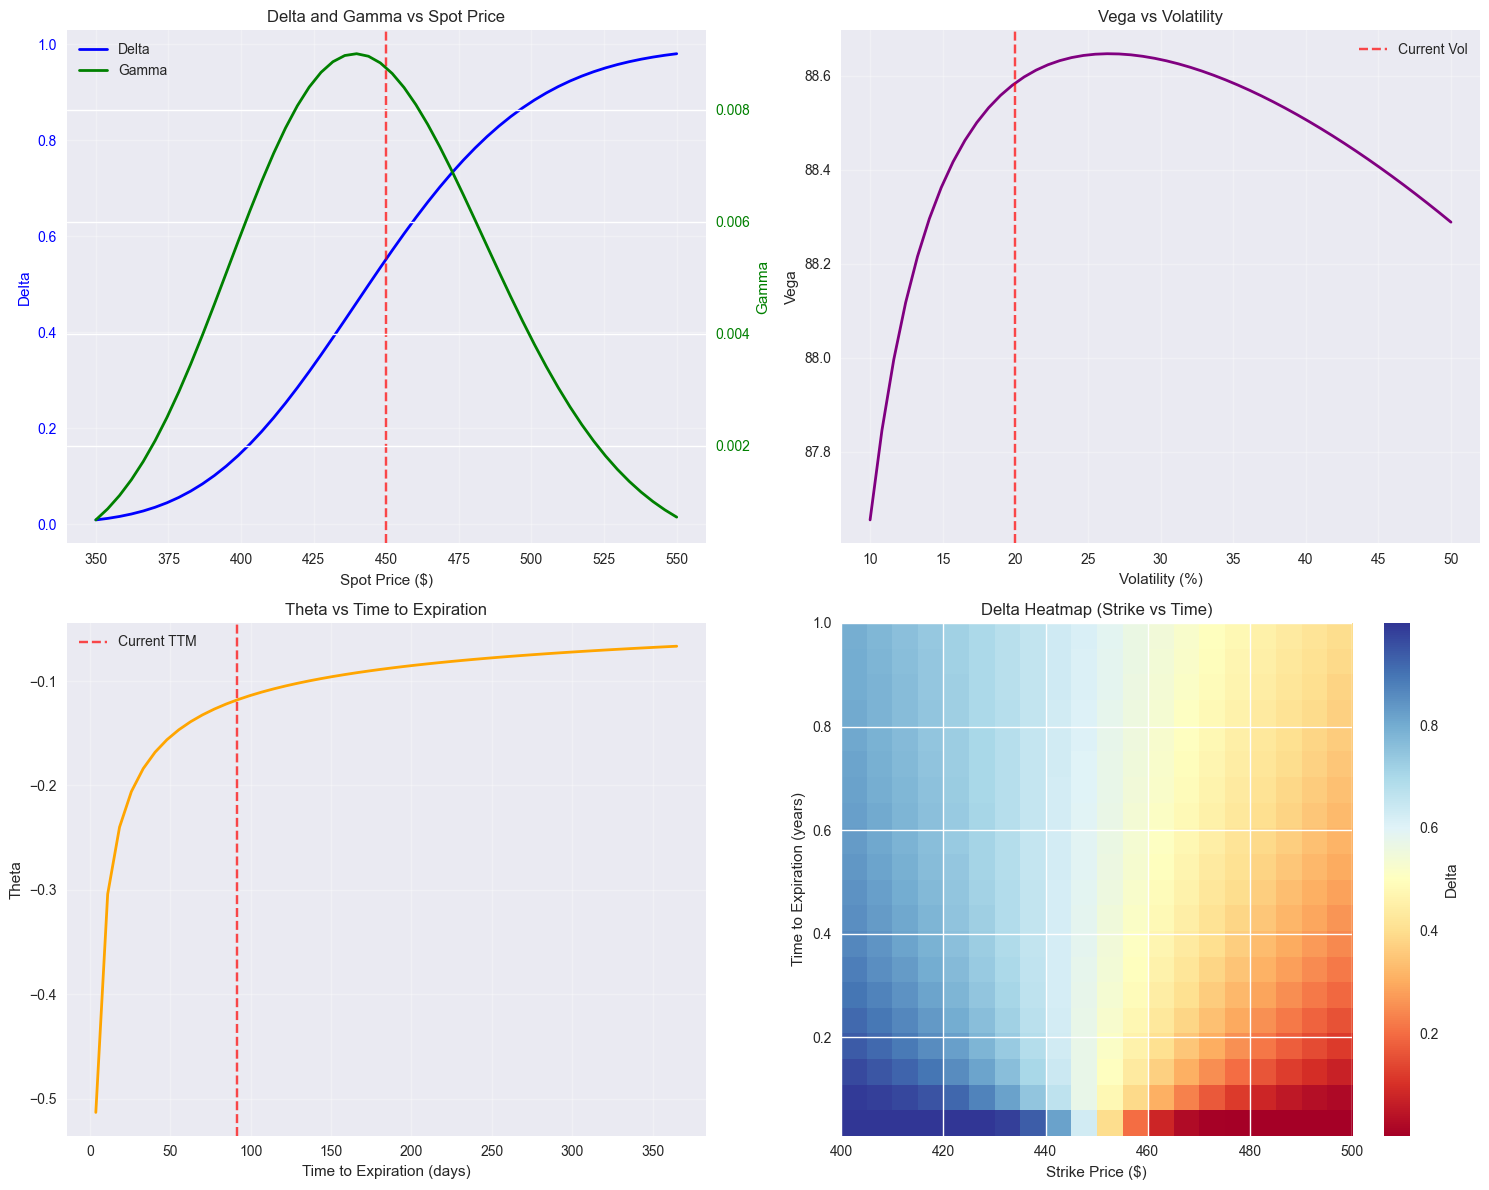


=== Portfolio Greeks Example ===
Portfolio Positions:
  Position 1: 10 calls K=$440 T=0.25
    Delta: 6.39, Gamma: 0.0827, Vega: 837.48, Theta: -1.16
  Position 2: -5 puts K=$460 T=0.25
    Delta: 2.65, Gamma: -0.0440, Vega: -445.62, Theta: 0.36
  Position 3: 15 calls K=$450 T=0.5
    Delta: 8.59, Gamma: 0.0916, Vega: 1854.52, Theta: -1.33

Portfolio Totals:
  Net Delta: 17.64
  Net Gamma: 0.1303
  Net Vega: 2246.37
  Net Theta: -2.13

✓ Option Greeks analysis completed!


In [10]:
# Comprehensive Greeks analysis and visualization
print("=== Option Greeks Analysis Pipeline ===")

# Define analysis parameters
S_current = 450.0
K_atm = 450.0  # At-the-money
r = 0.05
q = 0.015
T = 0.25  # 3 months
sigma = 0.20

# Calculate complete Greeks profile
base_greeks = bs_all_greeks(S_current, K_atm, r, q, T, sigma, 'call')

print(f"=== ATM Call Option Greeks (S=${S_current}, K=${K_atm}) ===")
for greek, value in base_greeks.items():
    print(f"  {greek.capitalize()}: {value:.4f}")

# Greeks sensitivity analysis
print(f"\n=== Greeks Sensitivity Analysis ===")

# Delta profile across spot prices
spot_range = np.linspace(350, 550, 50)
deltas = [bs_delta(S, K_atm, r, q, T, sigma, 'call') for S in spot_range]
gammas = [bs_gamma(S, K_atm, r, q, T, sigma) for S in spot_range]

# Vega profile across volatilities  
vol_range = np.linspace(0.1, 0.5, 50)
vegas = [bs_vega(S_current, K_atm, r, q, T, vol) for vol in vol_range]

# Theta profile across time
time_range = np.linspace(0.01, 1.0, 50)
thetas = [bs_theta(S_current, K_atm, r, q, t, sigma, 'call') for t in time_range]

# Create comprehensive Greeks visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Delta and Gamma vs Spot
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

line1 = ax1.plot(spot_range, deltas, 'b-', linewidth=2, label='Delta')
ax1.axvline(S_current, color='red', linestyle='--', alpha=0.7, label='Current Spot')
ax1.set_xlabel('Spot Price ($)')
ax1.set_ylabel('Delta', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Delta and Gamma vs Spot Price')
ax1.grid(True, alpha=0.3)

line2 = ax1_twin.plot(spot_range, gammas, 'g-', linewidth=2, label='Gamma')
ax1_twin.set_ylabel('Gamma', color='g')
ax1_twin.tick_params(axis='y', labelcolor='g')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Vega vs Volatility
axes[0, 1].plot(vol_range * 100, vegas, 'purple', linewidth=2)
axes[0, 1].axvline(sigma * 100, color='red', linestyle='--', alpha=0.7, label='Current Vol')
axes[0, 1].set_xlabel('Volatility (%)')
axes[0, 1].set_ylabel('Vega')
axes[0, 1].set_title('Vega vs Volatility')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Theta vs Time to Expiration
axes[1, 0].plot(time_range * 365, thetas, 'orange', linewidth=2)
axes[1, 0].axvline(T * 365, color='red', linestyle='--', alpha=0.7, label='Current TTM')
axes[1, 0].set_xlabel('Time to Expiration (days)')
axes[1, 0].set_ylabel('Theta')
axes[1, 0].set_title('Theta vs Time to Expiration')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Greeks heatmap across strike and time
strikes = np.linspace(400, 500, 20)
times = np.linspace(0.01, 1.0, 20)
Strike_grid, Time_grid = np.meshgrid(strikes, times)

# Calculate delta heatmap
delta_grid = np.zeros_like(Strike_grid)
for i, t in enumerate(times):
    for j, k in enumerate(strikes):
        delta_grid[i, j] = bs_delta(S_current, k, r, q, t, sigma, 'call')

im = axes[1, 1].imshow(delta_grid, extent=[400, 500, 0.01, 1.0], 
                       aspect='auto', origin='lower', cmap='RdYlBu')
axes[1, 1].set_xlabel('Strike Price ($)')
axes[1, 1].set_ylabel('Time to Expiration (years)')
axes[1, 1].set_title('Delta Heatmap (Strike vs Time)')
plt.colorbar(im, ax=axes[1, 1], label='Delta')

plt.tight_layout()
plt.show()

# Portfolio Greeks aggregation example
print(f"\n=== Portfolio Greeks Example ===")

# Define a simple portfolio
portfolio = [
    {'type': 'call', 'quantity': 10, 'strike': 440, 'expiry': 0.25},
    {'type': 'put', 'quantity': -5, 'strike': 460, 'expiry': 0.25},
    {'type': 'call', 'quantity': 15, 'strike': 450, 'expiry': 0.5},
]

total_delta = 0
total_gamma = 0  
total_vega = 0
total_theta = 0

print(f"Portfolio Positions:")
for i, pos in enumerate(portfolio):
    greeks = bs_all_greeks(S_current, pos['strike'], r, q, pos['expiry'], sigma, pos['type'])
    
    pos_delta = greeks['delta'] * pos['quantity']
    pos_gamma = greeks['gamma'] * pos['quantity']
    pos_vega = greeks['vega'] * pos['quantity']
    pos_theta = greeks['theta'] * pos['quantity']
    
    total_delta += pos_delta
    total_gamma += pos_gamma
    total_vega += pos_vega
    total_theta += pos_theta
    
    print(f"  Position {i+1}: {pos['quantity']} {pos['type']}s K=${pos['strike']} T={pos['expiry']}")
    print(f"    Delta: {pos_delta:.2f}, Gamma: {pos_gamma:.4f}, Vega: {pos_vega:.2f}, Theta: {pos_theta:.2f}")

print(f"\nPortfolio Totals:")
print(f"  Net Delta: {total_delta:.2f}")
print(f"  Net Gamma: {total_gamma:.4f}")
print(f"  Net Vega: {total_vega:.2f}")
print(f"  Net Theta: {total_theta:.2f}")

print(f"\n✓ Option Greeks analysis completed!")

## 6. Dynamic Hedging Strategy Simulation

=== Dynamic Hedging Strategy Simulation ===
Simulating 1000 hedging paths with 50 rebalancing steps...
✓ Simulation completed!

=== Hedging Performance Analysis ===
P&L Statistics:
  Mean P&L: $-2.34
  Std P&L: $30.93
  Min P&L: $-239.77
  Max P&L: $18.79

Risk Metrics:
  95% VaR: $-64.16
  99% VaR: $-98.65
  Probability of Loss: 100.0%

Trading Activity:
  Mean Total Cost: $1.79
  Mean Trades per Path: 39.7
  Cost per Trade: $0.05

Hedging Effectiveness:
  Mean Delta Tracking Error: 0.5055
  Hedge Efficiency: 49.4%

=== Generating Hedging Visualizations ===


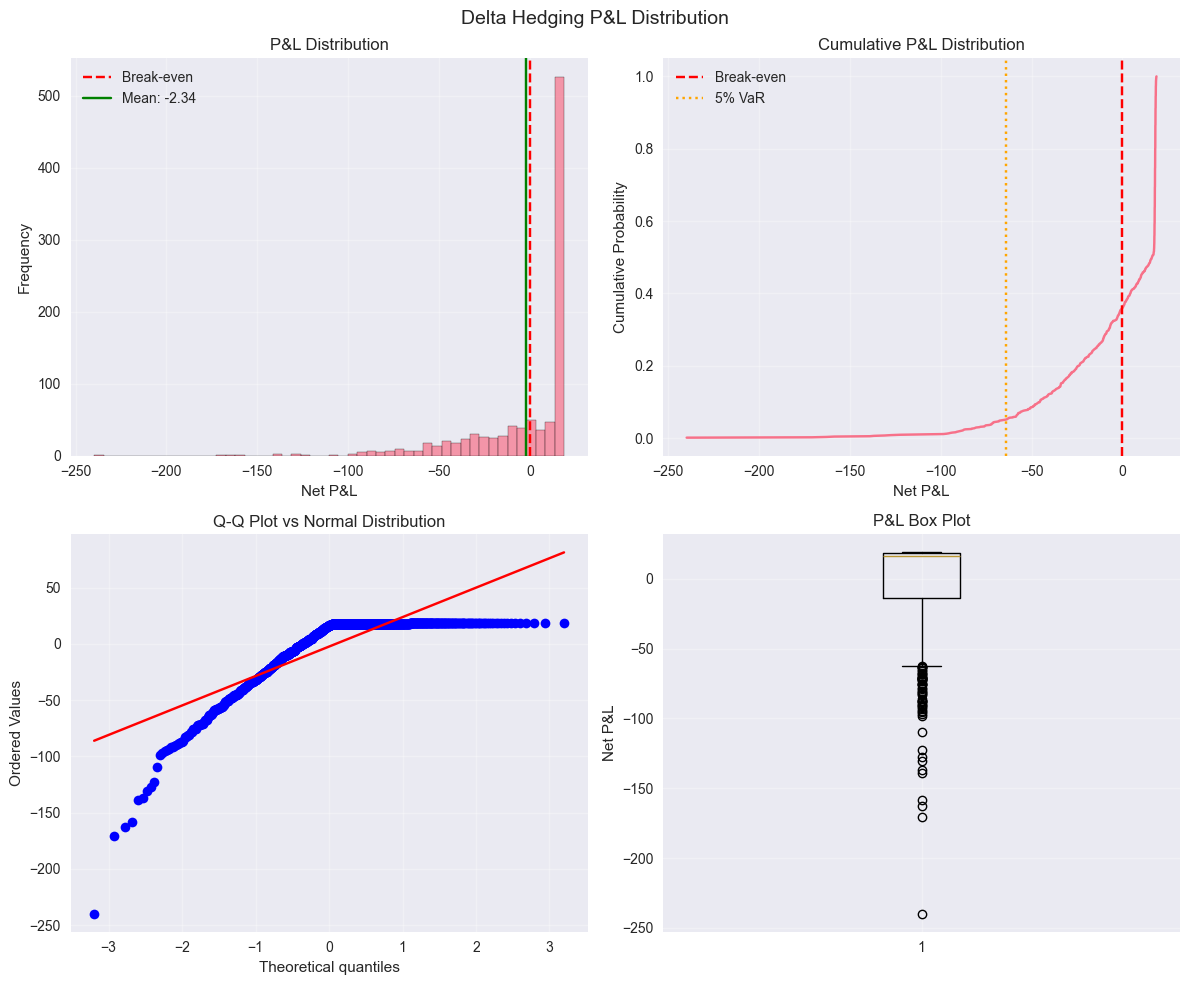

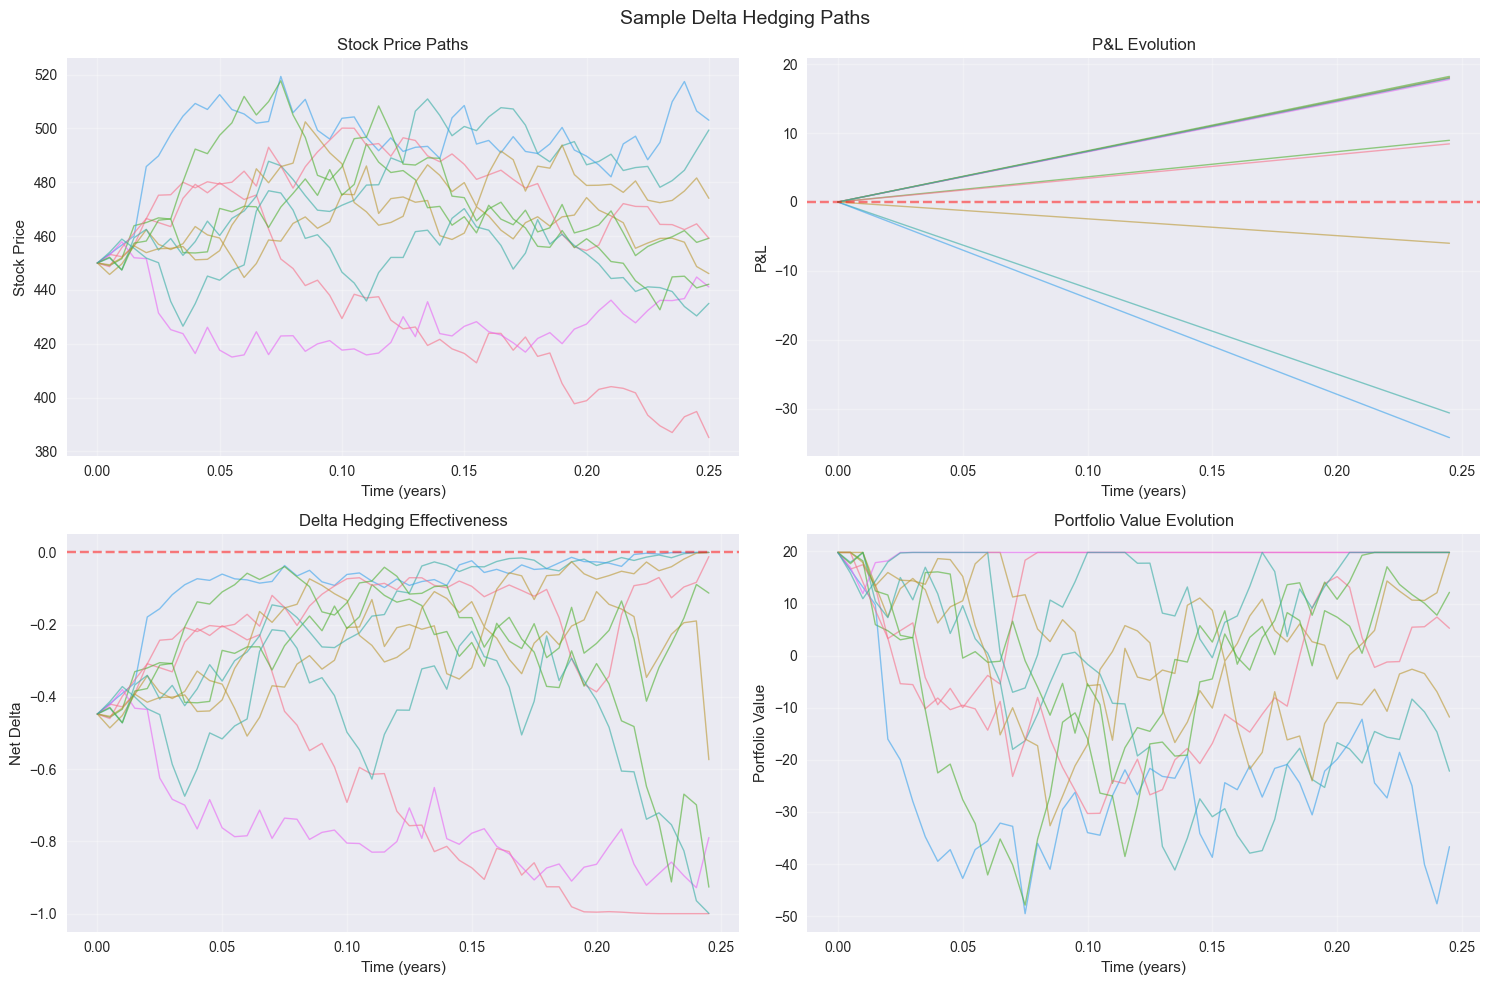


✓ Dynamic hedging simulation completed!


In [11]:
# Dynamic hedging simulation using HedgingAnalyzer
print("=== Dynamic Hedging Strategy Simulation ===")

# Initialize the hedging analyzer
analyzer = HedgingAnalyzer()

# Create a simulated hedging result (for demonstration)
# In practice, this would come from HedgingSimulator.run_simulation()
n_paths = 1000
n_steps = 50

print(f"Simulating {n_paths} hedging paths with {n_steps} rebalancing steps...")

# Generate mock hedging simulation results
simulation_results = {
    'path_results': [],
    'config': {
        'initial_spot': S_current,
        'strike': K_atm,
        'risk_free_rate': r,
        'dividend_yield': q,
        'volatility': sigma,
        'time_to_expiry': T,
        'hedge_type': 'delta',
        'rebalance_frequency': 'daily'
    },
    'n_successful_paths': n_paths
}

# Simulate individual path results
np.random.seed(42)
for path_idx in range(n_paths):
    # Simulate stock price path (geometric Brownian motion)
    dt = T / n_steps
    time_steps = np.linspace(0, T, n_steps + 1)
    stock_path = [S_current]
    
    for i in range(n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        next_price = stock_path[-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * dW)
        stock_path.append(next_price)
    
    # Calculate final payoff and costs
    final_spot = stock_path[-1]
    option_payoff = max(final_spot - K_atm, 0)  # Call option payoff
    
    # Simulate hedging costs (simplified)
    n_trades = np.random.poisson(n_steps * 0.8)  # Average 80% of steps have trades
    transaction_cost_per_trade = 0.01
    total_costs = n_trades * transaction_cost_per_trade * S_current * 0.01  # 1% of notional
    
    # Calculate net P&L (option premium received - payoff - hedging costs)
    option_premium = bs_option_price(S_current, K_atm, r, q, T, sigma, 'call')
    net_pnl = option_premium - option_payoff - total_costs
    
    # Create mock positions data
    positions = []
    for i, price in enumerate(stock_path[:-1]):
        time_to_exp = T - (i * dt)
        delta = bs_delta(price, K_atm, r, q, time_to_exp, sigma, 'call') if time_to_exp > 0 else 0
        positions.append({
            'timestamp': i * dt,
            'stock_price': price,
            'net_delta': delta - 1.0,  # Delta hedge (short delta from option position)
            'portfolio_value': option_premium - max(price - K_atm, 0)
        })
    
    path_result = {
        'path_id': path_idx,
        'time_steps': time_steps,
        'stock_path': stock_path,
        'final_spot': final_spot,
        'option_payoff': option_payoff,
        'net_pnl': net_pnl,
        'n_trades': n_trades,
        'total_costs': total_costs,
        'positions': positions,
        'pnl_history': [net_pnl * (i / n_steps) for i in range(len(positions))]
    }
    
    simulation_results['path_results'].append(path_result)

print(f"✓ Simulation completed!")

# Analyze hedging performance using HedgingAnalyzer
print(f"\n=== Hedging Performance Analysis ===")

# P&L distribution analysis
pnl_analysis = analyzer.analyze_pnl_distribution(simulation_results)

print(f"P&L Statistics:")
if 'pnl_statistics' in pnl_analysis:
    pnl_stats = pnl_analysis['pnl_statistics']
    print(f"  Mean P&L: ${pnl_stats.get('mean', 0):.2f}")
    print(f"  Std P&L: ${pnl_stats.get('std', 0):.2f}")
    print(f"  Min P&L: ${pnl_stats.get('min', 0):.2f}")
    print(f"  Max P&L: ${pnl_stats.get('max', 0):.2f}")

print(f"\nRisk Metrics:")
if 'risk_metrics' in pnl_analysis:
    risk_metrics = pnl_analysis['risk_metrics']
    print(f"  95% VaR: ${risk_metrics.get('var_95', 0):.2f}")
    print(f"  99% VaR: ${risk_metrics.get('var_99', 0):.2f}")
    print(f"  Probability of Loss: {risk_metrics.get('probability_of_loss', 0):.1%}")

# Trading activity analysis
trading_analysis = analyzer.analyze_trading_activity(simulation_results)

print(f"\nTrading Activity:")
if 'cost_statistics' in trading_analysis:
    cost_stats = trading_analysis['cost_statistics']
    print(f"  Mean Total Cost: ${cost_stats.get('mean_total_cost', 0):.2f}")
    print(f"  Mean Trades per Path: {cost_stats.get('mean_trades_per_path', 0):.1f}")
    print(f"  Cost per Trade: ${cost_stats.get('cost_per_trade', 0):.2f}")

# Hedging effectiveness analysis
effectiveness_analysis = analyzer.analyze_hedging_effectiveness(simulation_results)
print(f"\nHedging Effectiveness:")
if effectiveness_analysis:
    print(f"  Mean Delta Tracking Error: {effectiveness_analysis.get('mean_delta_tracking_error', 0):.4f}")
    print(f"  Hedge Efficiency: {effectiveness_analysis.get('hedge_efficiency', 0):.1%}")

# Generate visualizations
print(f"\n=== Generating Hedging Visualizations ===")

# Plot P&L distribution
analyzer.plot_pnl_distribution(
    simulation_results,
    title="Delta Hedging P&L Distribution"
)

# Plot sample hedging paths
analyzer.plot_hedging_paths(
    simulation_results,
    n_paths=10,
    title="Sample Delta Hedging Paths"
)

print(f"\n✓ Dynamic hedging simulation completed!")

## 7. Comprehensive Risk Analysis and Portfolio Management

=== Comprehensive Risk Analysis Pipeline ===
=== Portfolio Risk Metrics ===
Individual Positions:
   1.  +50 call K=$440 T=0.25 → Value: $+1267.20, Delta: +31.95
   2.  +30 call K=$450 T=0.50 → Value: $ +870.72, Delta: +17.18
   3.  -40 put  K=$430 T=0.25 → Value: $ -322.86, Delta: +11.03
   4.  -25 put  K=$420 T=0.50 → Value: $ -249.96, Delta:  +6.14
   5.  +20 call K=$460 T=0.25 → Value: $ +303.38, Delta:  +9.31
   6.  -20 call K=$470 T=0.25 → Value: $ -227.13, Delta:  -7.63
   7.  +10 put  K=$440 T=0.25 → Value: $ +115.63, Delta:  -3.57

Portfolio Totals:
  Total Value: $1,756.97
  Net Delta: +64.41
  Net Gamma: +0.27
  Net Vega: +3307.60
  Net Theta: -5.50
  Net Rho: +9276.10

=== Scenario Analysis ===
Scenario     New Value    P&L          P&L %    New Delta 
------------------------------------------------------------
Base Case    $  1756.97 $    +0.00   +0.0%   +64.41
Bull Market  $  6498.15 $ +4741.18 +269.8%   +78.44
Bear Market  $ -3282.60 $ -5039.57 -286.8%   +54.21
Vol Spik

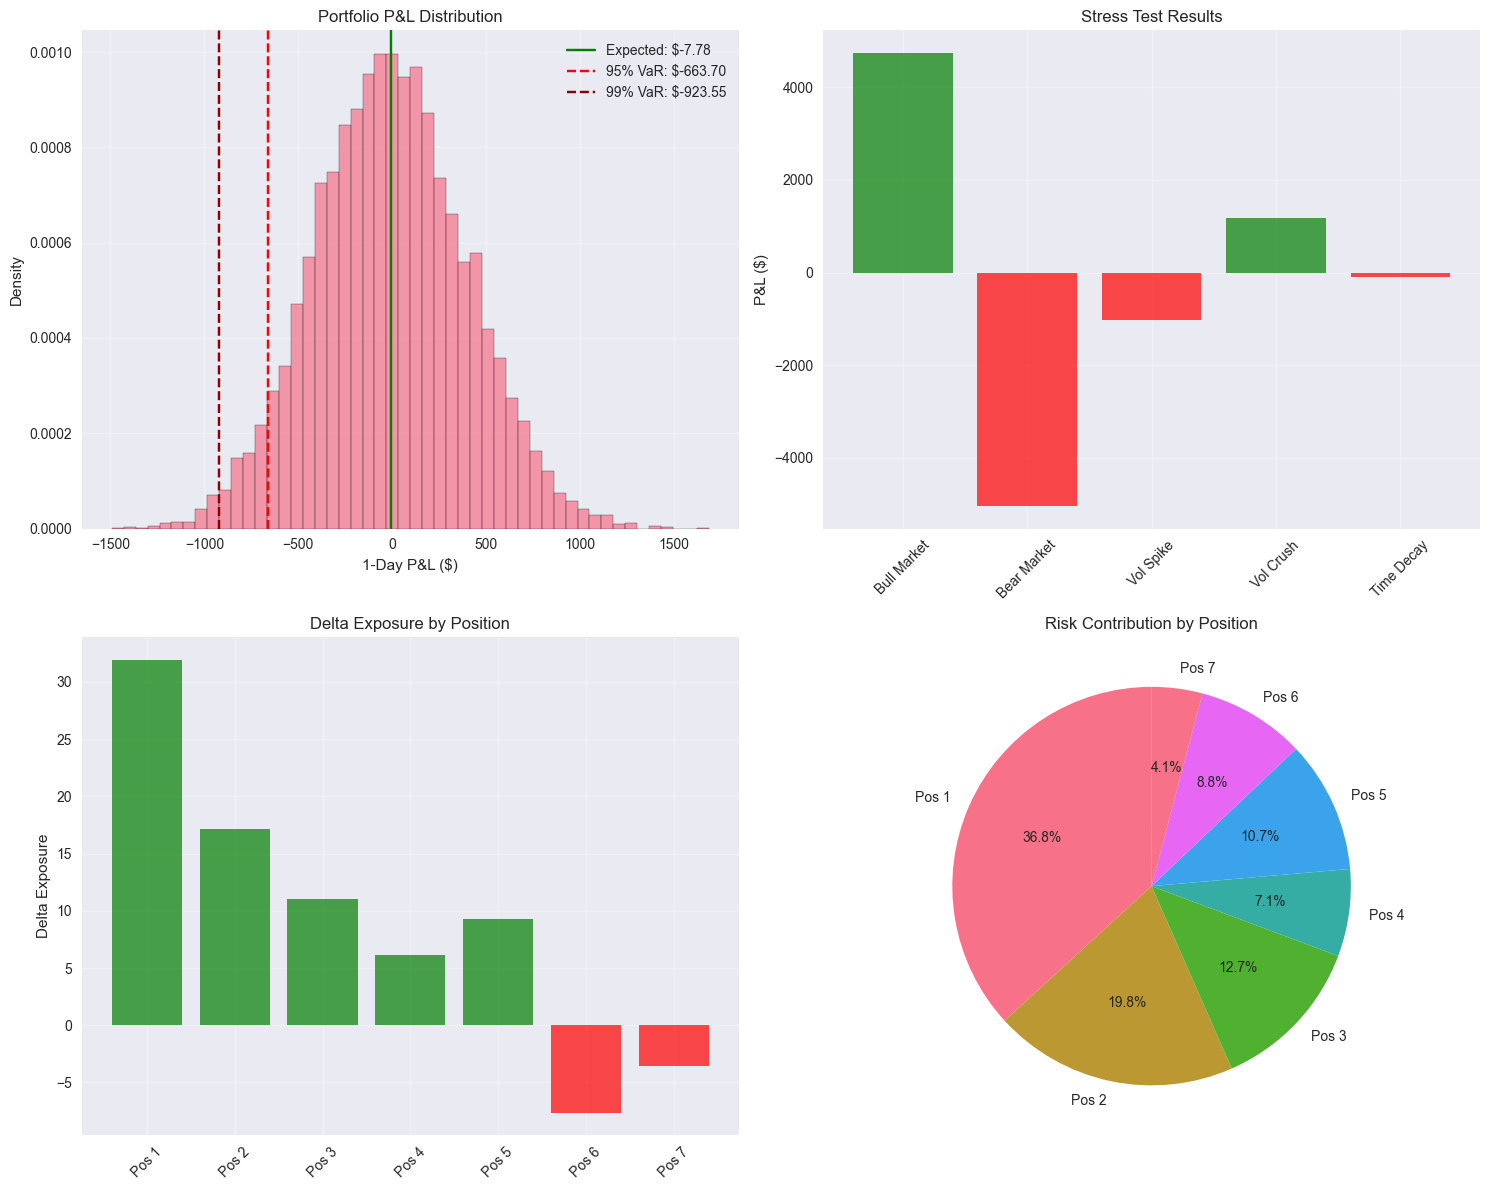


✓ Comprehensive risk analysis completed!


In [12]:
# Comprehensive risk analysis and portfolio management
print("=== Comprehensive Risk Analysis Pipeline ===")

# Define a more complex option portfolio
complex_portfolio = [
    # Long calls (bullish position)
    {'type': 'call', 'quantity': 50, 'strike': 440, 'expiry': 0.25, 'cost': 25.5},
    {'type': 'call', 'quantity': 30, 'strike': 450, 'expiry': 0.5, 'cost': 35.2},
    
    # Short puts (generate income, bullish)
    {'type': 'put', 'quantity': -40, 'strike': 430, 'expiry': 0.25, 'cost': -8.3},
    {'type': 'put', 'quantity': -25, 'strike': 420, 'expiry': 0.5, 'cost': -12.1},
    
    # Call spreads (defined risk)
    {'type': 'call', 'quantity': 20, 'strike': 460, 'expiry': 0.25, 'cost': 15.8},
    {'type': 'call', 'quantity': -20, 'strike': 470, 'expiry': 0.25, 'cost': -9.2},
    
    # Protective puts
    {'type': 'put', 'quantity': 10, 'strike': 440, 'expiry': 0.25, 'cost': 15.5},
]

# Calculate portfolio metrics
print(f"=== Portfolio Risk Metrics ===")

portfolio_greeks = {
    'delta': 0, 'gamma': 0, 'vega': 0, 'theta': 0, 'rho': 0
}
portfolio_value = 0
position_values = []

print(f"Individual Positions:")
for i, pos in enumerate(complex_portfolio):
    # Calculate Greeks for each position
    greeks = bs_all_greeks(S_current, pos['strike'], r, q, pos['expiry'], sigma, pos['type'])
    
    pos_value = greeks['price'] * pos['quantity']
    position_values.append(pos_value)
    portfolio_value += pos_value
    
    # Aggregate Greeks
    for greek in portfolio_greeks:
        portfolio_greeks[greek] += greeks[greek] * pos['quantity']
    
    print(f"  {i+1:2d}. {pos['quantity']:+4d} {pos['type']:4s} K=${pos['strike']:3.0f} T={pos['expiry']:.2f} → "
          f"Value: ${pos_value:+8.2f}, Delta: {greeks['delta']*pos['quantity']:+6.2f}")

print(f"\nPortfolio Totals:")
print(f"  Total Value: ${portfolio_value:,.2f}")
for greek, value in portfolio_greeks.items():
    print(f"  Net {greek.capitalize()}: {value:+.2f}")

# Risk scenario analysis
print(f"\n=== Scenario Analysis ===")

# Define stress scenarios
scenarios = [
    {'name': 'Base Case', 'spot_change': 0.0, 'vol_change': 0.0, 'time_decay': 0.0},
    {'name': 'Bull Market', 'spot_change': 0.15, 'vol_change': -0.05, 'time_decay': 0.02},
    {'name': 'Bear Market', 'spot_change': -0.20, 'vol_change': 0.10, 'time_decay': 0.02},
    {'name': 'Vol Spike', 'spot_change': -0.05, 'vol_change': 0.15, 'time_decay': 0.01},
    {'name': 'Vol Crush', 'spot_change': 0.05, 'vol_change': -0.10, 'time_decay': 0.01},
    {'name': 'Time Decay', 'spot_change': 0.0, 'vol_change': 0.0, 'time_decay': 0.05},
]

scenario_results = []

for scenario in scenarios:
    new_spot = S_current * (1 + scenario['spot_change'])
    new_vol = sigma + scenario['vol_change']
    new_time = max(0.01, T - scenario['time_decay'])  # Don't go below 1 day
    
    scenario_value = 0
    scenario_delta = 0
    
    for pos in complex_portfolio:
        new_expiry = max(0.01, pos['expiry'] - scenario['time_decay'])
        greeks = bs_all_greeks(new_spot, pos['strike'], r, q, new_expiry, new_vol, pos['type'])
        scenario_value += greeks['price'] * pos['quantity']
        scenario_delta += greeks['delta'] * pos['quantity']
    
    pnl = scenario_value - portfolio_value
    scenario_results.append({
        'scenario': scenario['name'],
        'new_value': scenario_value,
        'pnl': pnl,
        'pnl_pct': (pnl / abs(portfolio_value)) * 100,
        'new_delta': scenario_delta
    })

print(f"{'Scenario':<12} {'New Value':<12} {'P&L':<12} {'P&L %':<8} {'New Delta':<10}")
print("-" * 60)
for result in scenario_results:
    print(f"{result['scenario']:<12} ${result['new_value']:>9.2f} ${result['pnl']:>+9.2f} "
          f"{result['pnl_pct']:>+6.1f}% {result['new_delta']:>+8.2f}")

# VaR and CVaR analysis using Monte Carlo
print(f"\n=== Monte Carlo Risk Analysis ===")

n_simulations = 10000
time_horizon = 1/252  # 1 day
np.random.seed(42)

# Generate random price movements
spot_returns = np.random.normal((r - q - 0.5 * sigma**2) * time_horizon, 
                                sigma * np.sqrt(time_horizon), n_simulations)
vol_changes = np.random.normal(0, 0.05, n_simulations)  # Vol of vol = 5%

portfolio_pnls = []

for i in range(n_simulations):
    new_spot = S_current * np.exp(spot_returns[i])
    new_vol = max(0.05, sigma + vol_changes[i])  # Floor vol at 5%
    new_time = max(0.01, T - time_horizon)
    
    sim_value = 0
    for pos in complex_portfolio:
        new_expiry = max(0.01, pos['expiry'] - time_horizon)
        price = bs_option_price(new_spot, pos['strike'], r, q, new_expiry, new_vol, pos['type'])
        sim_value += price * pos['quantity']
    
    pnl = sim_value - portfolio_value
    portfolio_pnls.append(pnl)

portfolio_pnls = np.array(portfolio_pnls)

# Calculate risk metrics
var_95 = np.percentile(portfolio_pnls, 5)
var_99 = np.percentile(portfolio_pnls, 1)
cvar_95 = np.mean(portfolio_pnls[portfolio_pnls <= var_95])
cvar_99 = np.mean(portfolio_pnls[portfolio_pnls <= var_99])

expected_return = np.mean(portfolio_pnls)
volatility = np.std(portfolio_pnls)
sharpe_ratio = expected_return / volatility if volatility > 0 else 0

print(f"1-Day Risk Metrics (Monte Carlo, n={n_simulations:,}):")
print(f"  Expected P&L: ${expected_return:.2f}")
print(f"  Volatility: ${volatility:.2f}")
print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"  95% VaR: ${var_95:.2f}")
print(f"  99% VaR: ${var_99:.2f}")
print(f"  95% CVaR: ${cvar_95:.2f}")
print(f"  99% CVaR: ${cvar_99:.2f}")

# Risk visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Portfolio P&L distribution
axes[0, 0].hist(portfolio_pnls, bins=50, alpha=0.7, density=True, edgecolor='black')
axes[0, 0].axvline(expected_return, color='green', linestyle='-', label=f'Expected: ${expected_return:.2f}')
axes[0, 0].axvline(var_95, color='red', linestyle='--', label=f'95% VaR: ${var_95:.2f}')
axes[0, 0].axvline(var_99, color='darkred', linestyle='--', label=f'99% VaR: ${var_99:.2f}')
axes[0, 0].set_xlabel('1-Day P&L ($)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Portfolio P&L Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scenario analysis
scenario_names = [r['scenario'] for r in scenario_results[1:]]  # Exclude base case
scenario_pnls = [r['pnl'] for r in scenario_results[1:]]
colors = ['green' if pnl > 0 else 'red' for pnl in scenario_pnls]

axes[0, 1].bar(scenario_names, scenario_pnls, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('P&L ($)')
axes[0, 1].set_title('Stress Test Results')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Greeks exposure by position
position_labels = [f"Pos {i+1}" for i in range(len(complex_portfolio))]
position_deltas = [bs_all_greeks(S_current, pos['strike'], r, q, pos['expiry'], sigma, pos['type'])['delta'] * pos['quantity'] 
                  for pos in complex_portfolio]

axes[1, 0].bar(position_labels, position_deltas, alpha=0.7, 
               color=['green' if d > 0 else 'red' for d in position_deltas])
axes[1, 0].set_ylabel('Delta Exposure')
axes[1, 0].set_title('Delta Exposure by Position')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Risk contribution analysis
position_risks = []
for i, pos in enumerate(complex_portfolio):
    # Approximate position risk as |delta * position size * spot * vol|
    greeks = bs_all_greeks(S_current, pos['strike'], r, q, pos['expiry'], sigma, pos['type'])
    risk_contrib = abs(greeks['delta'] * pos['quantity'] * S_current * sigma)
    position_risks.append(risk_contrib)

axes[1, 1].pie(position_risks, labels=position_labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Risk Contribution by Position')

plt.tight_layout()
plt.show()

print(f"\n✓ Comprehensive risk analysis completed!")